In [ ]:

import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Cifar10
# labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# MNIST
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [ ]:
# Pre-process data
img_rows, img_cols, channels = 28, 28, 1 # 32, 32, 3
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [ ]:
# Create model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [ ]:
# Create and fit model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                        

In [ ]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0200 - accuracy: 0.8616 - val_loss: 0.0071 - val_accuracy: 0.9533
Epoch 2/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0092 - accuracy: 0.9403 - val_loss: 0.0050 - val_accuracy: 0.9687
Epoch 3/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0075 - accuracy: 0.9514 - val_loss: 0.0045 - val_accuracy: 0.9708
Epoch 4/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0064 - accuracy: 0.9593 - val_loss: 0.0044 - val_accuracy: 0.9712
Epoch 5/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0059 - accuracy: 0.9623 - val_loss: 0.0038 - val_accuracy: 0.9760
Epoch 6/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0054 - accuracy: 0.9654 - val_loss: 0.0034 - val_accuracy: 0.9776
Epoch 7/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0050 - accuracy: 0.9685 - val_loss: 0.0035 - val_ac

In [ ]:
# Assess base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.0030909040942788124, 0.9811000227928162]


# **ATTACK**

In [ ]:
# Function to create adversarial pattern
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

five
three


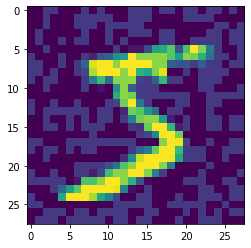

In [ ]:
# Create a signle adversarial example
image = x_train[0]
image_label = y_train[0]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1

print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

DEFENSE

In [ ]:
# Adversarial data generator
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

Prediction: nine Truth: four


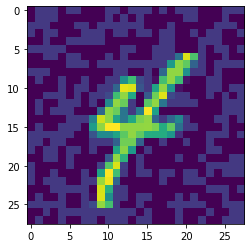

Prediction: five Truth: five


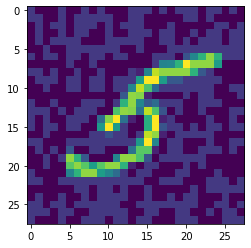

Prediction: eight Truth: eight


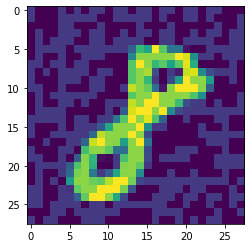

Prediction: six Truth: six


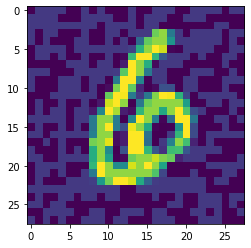

Prediction: three Truth: seven


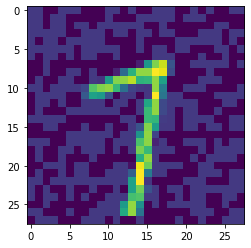

Prediction: five Truth: four


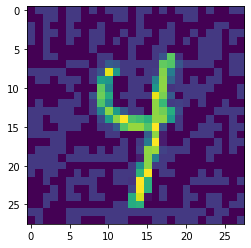

Prediction: six Truth: six


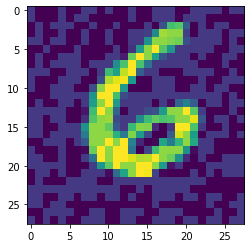

Prediction: five Truth: five


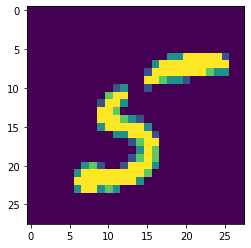

Prediction: seven Truth: nine


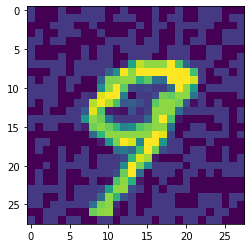

Prediction: five Truth: six


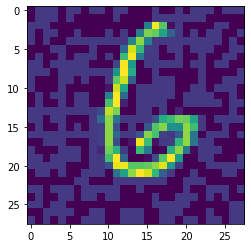

Prediction: three Truth: three


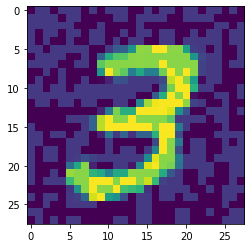

Prediction: nine Truth: nine


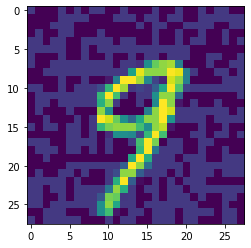

In [ ]:
# Generate and visualize 12 adversarial images
adversarials, correct_labels = next(generate_adversarials(12))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], 'Truth:', labels[correct_label.argmax()])
    if channels == 1:
        plt.imshow(adversarial.reshape(img_rows, img_cols))
    else:
        plt.imshow(adversarial)






        
    plt.show()

In [ ]:
# Generate adversarial data
# x_adversarial, y_adversarial = np.load("x_adv_10k.npy"), np.load("y_adv_10k.npy")
x_adversarial_train, y_adversarial_train = next(generate_adversarials(5))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(5))

In [ ]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.0855957642197609, 0.6000000238418579]


# **DEFENSE**

In [ ]:
# Learn from adversarial data
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.0936 - accuracy: 0.4000 - val_loss: 0.0031 - val_accuracy: 0.9813
Epoch 2/10
1/1 [==============================] - 1s 801ms/step - loss: 0.0775 - accuracy: 0.6000 - val_loss: 0.0031 - val_accuracy: 0.9813
Epoch 3/10
1/1 [==============================] - 1s 820ms/step - loss: 0.0802 - accuracy: 0.6000 - val_loss: 0.0031 - val_accuracy: 0.9813
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0747 - accuracy: 0.6000 - val_loss: 0.0030 - val_accuracy: 0.9817
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0807 - accuracy: 0.6000 - val_loss: 0.0030 - val_accuracy: 0.9814
Epoch 6/10
1/1 [==============================] - 1s 801ms/step - loss: 0.0798 - accuracy: 0.6000 - val_loss: 0.0030 - val_accuracy: 0.9814
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0794 - accuracy: 0.6000 - val_loss: 0.0030 - val_accuracy: 0.9813
Epoch 8/10
1/1 [================

In [ ]:

# Assess model after defense on regular data
print("After defense accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

After defense accuracy on regular images: [0.0030093754176050425, 0.9811999797821045]


In [ ]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("After defense accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

After defense accuracy on adversarial images: [0.10014750063419342, 0.4187999963760376]


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_adversarial_test.argmax(axis=1))

array([[119, 121,  66,  94, 106,  49, 119, 115,  74, 117],
       [161, 157,  76, 112, 108,  69, 100, 114, 101, 137],
       [130, 143,  57, 116, 114,  56, 122,  94,  91, 109],
       [137, 150,  53, 105, 114,  58, 116,  94,  66, 117],
       [141, 149,  48,  98,  94,  45, 106,  98,  96, 107],
       [110, 116,  57, 107,  94,  58,  93,  91,  62, 104],
       [129, 129,  58,  99,  81,  45,  93, 115,  84, 125],
       [141, 127,  63,  99, 101,  71, 132,  94,  90, 110],
       [145, 114,  53,  93, 114,  59, 107,  90,  82, 117],
       [117, 160,  59, 103, 118,  56, 111,  92,  78, 115]])

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_adversarial_test)

0.0974

In [ ]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_test, y_adversarial_test,average=None)

array([0.12142857, 0.13832599, 0.05523256, 0.1039604 , 0.09572301,
       0.06502242, 0.09707724, 0.09143969, 0.08418891, 0.11397423])

In [ ]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_test, y_adversarial_test, average=None)

array([0.08947368, 0.11493411, 0.09661017, 0.10233918, 0.09003831,
       0.1024735 , 0.08462238, 0.09428285, 0.09951456, 0.09930915])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_adversarial_test, average=None)

array([0.1030303 , 0.12554978, 0.0702836 , 0.10314342, 0.09279368,
       0.07956104, 0.09042295, 0.09283951, 0.09121246, 0.10613752])